<a href="https://colab.research.google.com/github/wakristensen/machine-learning-workshop/blob/main/03_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salgsprediksjon med regresjon og XGBoost

Vi skal:

1) Hente og preppe salgsdata

2) Lage et tidsserie-sett

3) Trene en regresjonsmodell og en XGBoost model

4) Evualere modellene

5) Gjøre fremtidige prediksjoner

## Importerer biblioteker

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Importerer datasettet

In [ ]:
file_id = "1Ku-y5BE5CdGQwzEMQ491cfIYWILS6T8U"
url = f"https://drive.google.com/uc?id={file_id}"

df = pd.read_csv(url, encoding="latin1")

## Preppe data for tidsserie-prediksjoner

In [ ]:
# --- Produktfokusert datasett for antall salg ---

# Sikre riktig dtype
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Fjerner kansellerte og negative linjer, slik at "antall salg" kun betyr positive salg
# Kansellerte transaksjoner har InvoiceNo som starter med 'C', negativ Quantity, og samme UnitPrice som originalen
df_prod = df.copy()

# Finne kansellerte transaksjoner
cancelled_transactions = df_prod[df_prod['InvoiceNo'].astype(str).str.startswith('C')].copy()

# Lager en unik nøkkel for å matche kansellerte transaksjoner med originale counterparts
cancelled_transactions['match_key'] = cancelled_transactions['StockCode'].astype(str) + '_' + \
                                      cancelled_transactions['CustomerID'].astype(str) + '_' + \
                                      (cancelled_transactions['Quantity'] * -1).astype(str) + '_' + \
                                      cancelled_transactions['UnitPrice'].astype(str)

# Finner originale transaksjoner som matcher de kansellerte
df_prod['match_key'] = df_prod['StockCode'].astype(str) + '_' + \
                       df_prod['CustomerID'].astype(str) + '_' + \
                       df_prod['Quantity'].astype(str) + '_' + \
                       df_prod['UnitPrice'].astype(str)

# Finner transaksjoner vi skal fjerne (kansellerte transaksjoner og deres positive counterparts)
keys_to_remove = cancelled_transactions['match_key'].tolist()

# Filtrerer vekk transaksjoner vi skal fjerne
df_prod = df_prod[~df_prod['match_key'].isin(keys_to_remove)].copy()

# Fjerner den midlertidig match-nøkkelen
df_prod = df_prod.drop(columns=['match_key'])

# Sikrer at utelukkende positive kvantiteter og unit priser står igje
df_prod = df_prod[(df_prod['Quantity'] > 0) & (df_prod['UnitPrice'] > 0)]


# Topp 10 etter frekvens av Description
top_products = df_prod['Description'].value_counts().head(10)
print("Topp 10 produkter:", top_products)

# Velg mest frekvente beskrivelse
TOP_PRODUCT = df_prod['Description'].value_counts().reset_index().iloc[2][0]
print("Produkt valgt (Description):", TOP_PRODUCT)

# Filtrer på Description, ikke StockCode
prod_df = df_prod[df_prod['Description'] == TOP_PRODUCT].copy()

# Sikre datetime og lag eksplisitt Date-kolonne
prod_df['InvoiceDate'] = pd.to_datetime(prod_df['InvoiceDate'], errors='coerce')
prod_df = prod_df.dropna(subset=['InvoiceDate'])

# Behold dtype datetime64 ved å normalisere til midnatt (bedre for plotting og sortering)
prod_df['Date'] = prod_df['InvoiceDate'].dt.normalize()

# Gruppér per dag og summer Quantity
daily_prod_sales = (
    prod_df
    .groupby('Date', as_index=False)['Quantity']
    .sum()
    .rename(columns={'Quantity': 'SalesCount'})
    .sort_values('Date')
)

print("Form på daglig datasett:", daily_prod_sales.shape)
daily_prod_sales

Topp 10 produkter: Description
WHITE HANGING HEART T-LIGHT HOLDER    2294
JUMBO BAG RED RETROSPOT               2087
REGENCY CAKESTAND 3 TIER              1928
PARTY BUNTING                         1684
LUNCH BAG RED RETROSPOT               1555
ASSORTED COLOUR BIRD ORNAMENT         1465
SET OF 3 CAKE TINS PANTRY DESIGN      1362
PACK OF 72 RETROSPOT CAKE CASES       1357
LUNCH BAG  BLACK SKULL.               1310
NATURAL SLATE HEART CHALKBOARD        1259
Name: count, dtype: int64
Produkt valgt (Description): REGENCY CAKESTAND 3 TIER
Form på daglig datasett: (299, 2)


/tmp/ipython-input-1650733905.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  TOP_PRODUCT = df_prod['Description'].value_counts().reset_index().iloc[2][0]


,Date,SalesCount
0,2010-12-01,115
1,2010-12-02,184
2,2010-12-03,225
3,2010-12-05,92
4,2010-12-06,156
...,...,...
294,2011-12-05,36
295,2011-12-06,159
296,2011-12-07,130
297,2011-12-08,31


In [ ]:
df_prod[df_prod.Description == "REGENCY CAKESTAND 3 TIER"].StockCode.value_counts()

,count
StockCode,
22423,1928


In [ ]:
df_prod[df_prod.StockCode == "22423"].sort_values('Quantity', ascending=False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
23263,538191,22423,REGENCY CAKESTAND 3 TIER,272,2010-12-10 10:49:00,10.95,15061.0,United Kingdom
282261,561633,22423,REGENCY CAKESTAND 3 TIER,192,2011-07-28 14:33:00,10.95,17949.0,United Kingdom
58117,541220,22423,REGENCY CAKESTAND 3 TIER,160,2011-01-14 14:11:00,10.95,14156.0,EIRE
4505,536785,22423,REGENCY CAKESTAND 3 TIER,144,2010-12-02 15:22:00,10.95,15061.0,United Kingdom
530516,580873,22423,REGENCY CAKESTAND 3 TIER,128,2011-12-06 12:06:00,10.95,15061.0,United Kingdom
377922,569570,22423,REGENCY CAKESTAND 3 TIER,120,2011-10-05 10:06:00,10.95,16684.0,United Kingdom
186918,552888,22423,REGENCY CAKESTAND 3 TIER,120,2011-05-12 10:23:00,10.95,15061.0,United Kingdom
212529,555490,22423,REGENCY CAKESTAND 3 TIER,120,2011-06-03 13:50:00,10.95,17949.0,United Kingdom
6607,536970,22423,REGENCY CAKESTAND 3 TIER,120,2010-12-03 13:12:00,10.95,17949.0,United Kingdom
263180,559941,22423,REGENCY CAKESTAND 3 TIER,112,2011-07-14 10:20:00,10.95,17396.0,United Kingdom


## Exploratory Data Analysis (EDA)

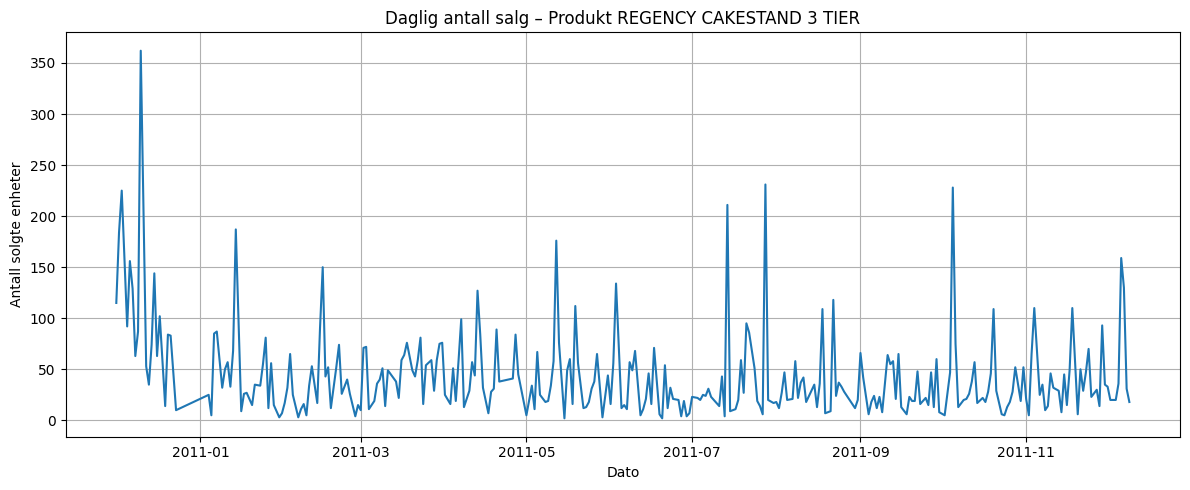

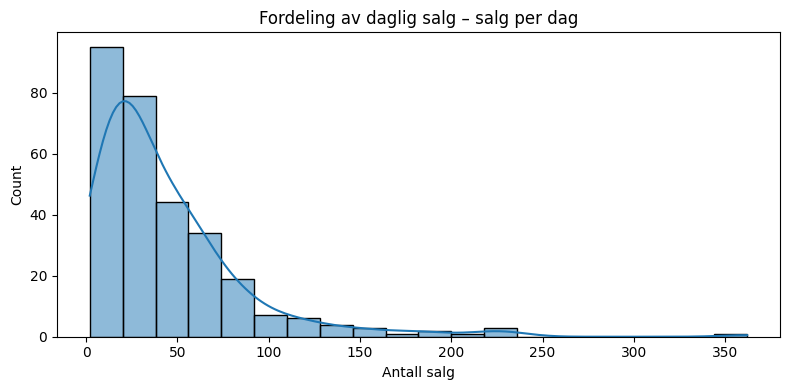

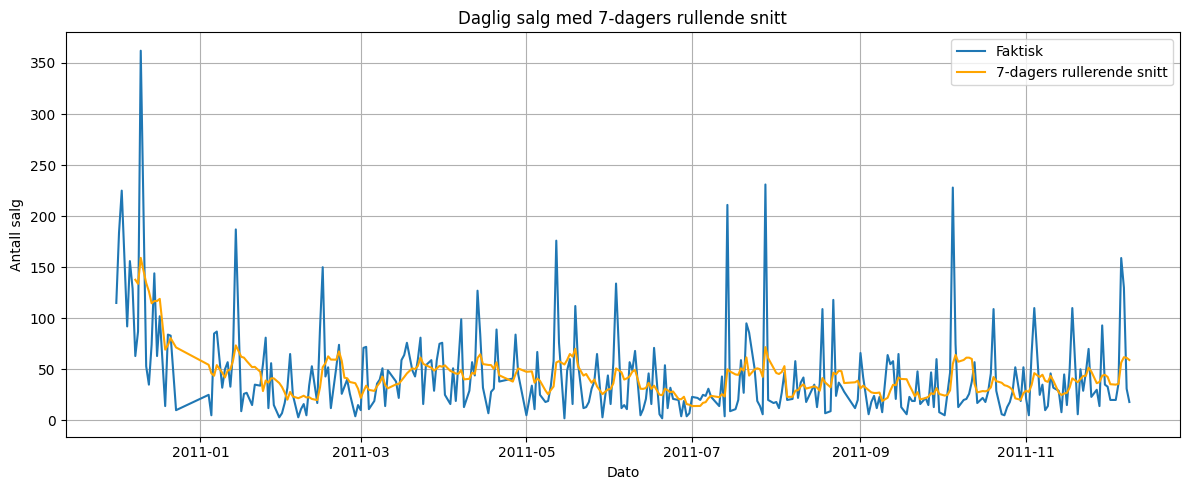

In [ ]:
# --- Blokk 4: EDA for det mest solgte produktet ---
import matplotlib.pyplot as plt
import seaborn as sns

# Plot daglig antall salg for toppproduktet
plt.figure(figsize=(12, 5))
sns.lineplot(x='Date', y='SalesCount', data=daily_prod_sales)
plt.title(f'Daglig antall salg – Produkt {TOP_PRODUCT}')
plt.xlabel('Dato')
plt.ylabel('Antall solgte enheter')
plt.grid(True)
plt.tight_layout()
plt.show()

# Fordeling av daglig antall salg
plt.figure(figsize=(8, 4))
sns.histplot(daily_prod_sales['SalesCount'], bins=20, kde=True)
plt.title('Fordeling av daglig salg – salg per dag')
plt.xlabel('Antall salg')
plt.tight_layout()
plt.show()

# Rullerende gjennomsnitt (7 dager)
daily_prod_sales['Rolling7'] = daily_prod_sales['SalesCount'].rolling(window=7).mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x='Date', y='SalesCount', label='Faktisk', data=daily_prod_sales)
sns.lineplot(x='Date', y='Rolling7', label='7-dagers rullerende snitt', data=daily_prod_sales, color='orange')
plt.title('Daglig salg med 7-dagers rullende snitt')
plt.xlabel('Dato')
plt.ylabel('Antall salg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- Features for antall salg  ---

def make_prod_features(df):
    df = df.copy()
    # Lag enkle tidsvariabler
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['dayofweek'] = df['Date'].dt.dayofweek  # 0 = mandag

    # Enkle lag og rullerende gjennomsnitt
    df['lag_1'] = df['SalesCount'].shift(1)
    df['lag_7'] = df['SalesCount'].shift(7)
    df['roll_mean_7'] = df['SalesCount'].rolling(7).mean()

    # Dropp NaN som kommer fra lag/rolling
    df = df.dropna()

    feature_cols = ['year', 'month', 'dayofweek', 'lag_1', 'lag_7', 'roll_mean_7']
    X = df[feature_cols]
    y = df['SalesCount']
    return df, X, y, feature_cols

features_df, X, y, feature_cols = make_prod_features(daily_prod_sales)
features_df


,Date,SalesCount,Rolling7,year,month,dayofweek,lag_1,lag_7,roll_mean_7
7,2010-12-09,87,133.714286,2010,12,3,63.0,115.0,133.714286
8,2010-12-10,362,159.142857,2010,12,4,87.0,184.0,159.142857
9,2010-12-12,53,134.571429,2010,12,6,362.0,225.0,134.571429
10,2010-12-13,35,126.428571,2010,12,0,53.0,92.0,126.428571
11,2010-12-14,74,114.714286,2010,12,1,35.0,156.0,114.714286
...,...,...,...,...,...,...,...,...,...
294,2011-12-05,36,35.857143,2011,12,0,20.0,30.0,35.857143
295,2011-12-06,159,56.571429,2011,12,1,36.0,14.0,56.571429
296,2011-12-07,130,61.857143,2011,12,2,159.0,93.0,61.857143
297,2011-12-08,31,61.285714,2011,12,3,130.0,35.0,61.285714


In [ ]:
X

,year,month,dayofweek,lag_1,lag_7,roll_mean_7
7,2010,12,3,63.0,115.0,133.714286
8,2010,12,4,87.0,184.0,159.142857
9,2010,12,6,362.0,225.0,134.571429
10,2010,12,0,53.0,92.0,126.428571
11,2010,12,1,35.0,156.0,114.714286
...,...,...,...,...,...,...
294,2011,12,0,20.0,30.0,35.857143
295,2011,12,1,36.0,14.0,56.571429
296,2011,12,2,159.0,93.0,61.857143
297,2011,12,3,130.0,35.0,61.285714


In [ ]:
# --- Trener to modeller og sammenligner ---

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Tidsserie-splitt: ikke shuffle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# 1) Lineær regresjon
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

# 2) XGBoost-regresjon
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=30
)
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgb.predict(X_test)

# Evaluer
def report(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.3f}")

print("Modellkvalitet på hold-out:")
report(y_test, y_pred_lin, "LinearRegression")
report(y_test, y_pred_xgb, "XGBRegressor")


Modellkvalitet på hold-out:
LinearRegression -> MAE: 27.06 | RMSE: 38.23 | R²: 0.094
XGBRegressor -> MAE: 24.08 | RMSE: 38.31 | R²: 0.090


MEA - Mean absolute error: Gjennomsnittlig absolutt feil i samme enhet som målvariabel, intuitiv å forstå

RMSE - Root mean squared error: Straffer store feil sterkere, følsom for outliers.

R² - bestemmelseskoeffisient (
  - 0	The model does not predict the outcome.
  - Between 0 and 1	The model partially predicts the outcome.
  - 1	The model perfectly predicts the outcome.)

R² sier noe om hvor mye av variasjonen modellen klarer å forklare med de parameterne den har.

# Modell-evaluering

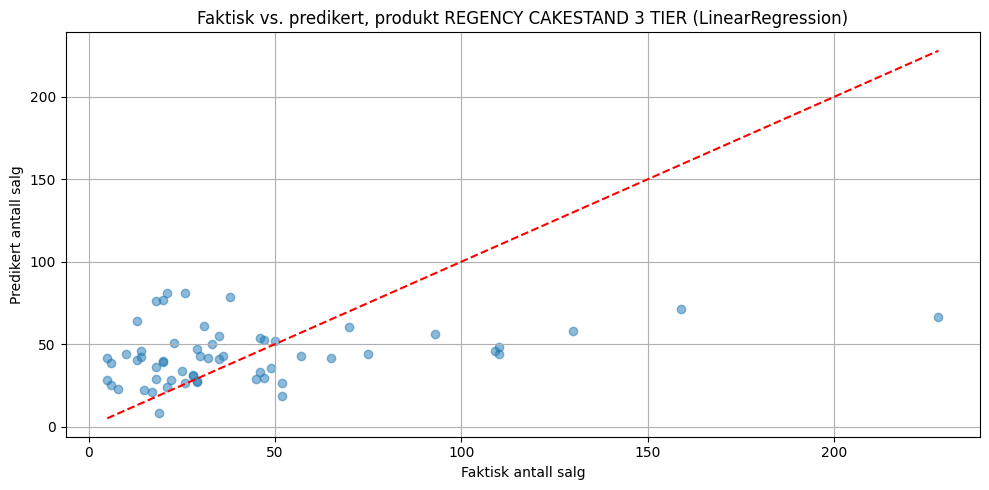

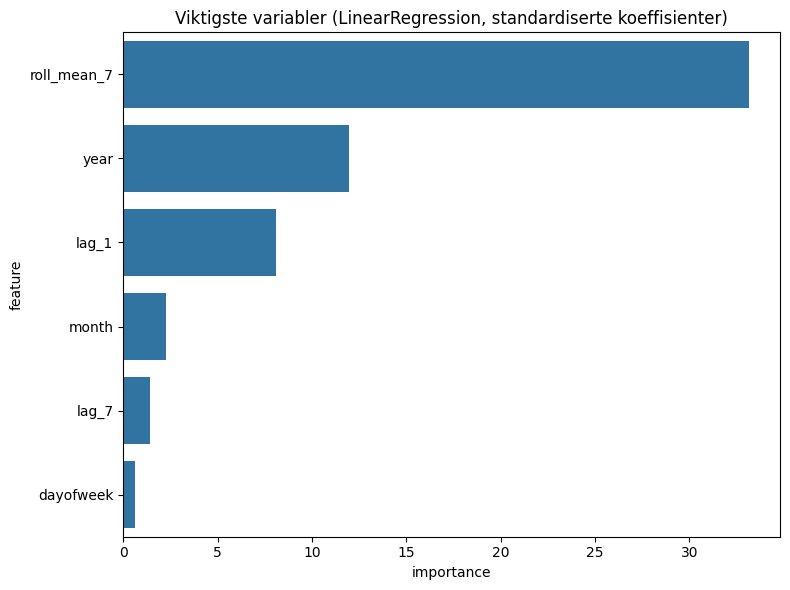

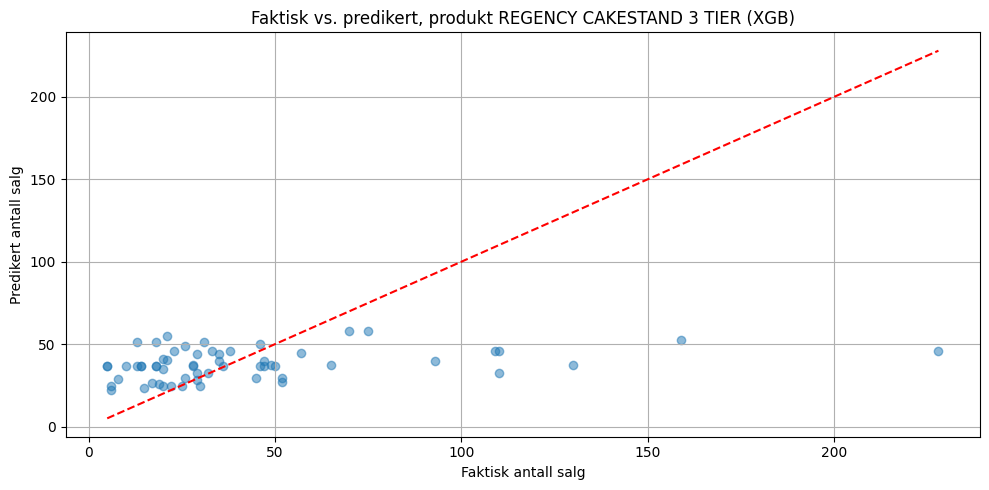

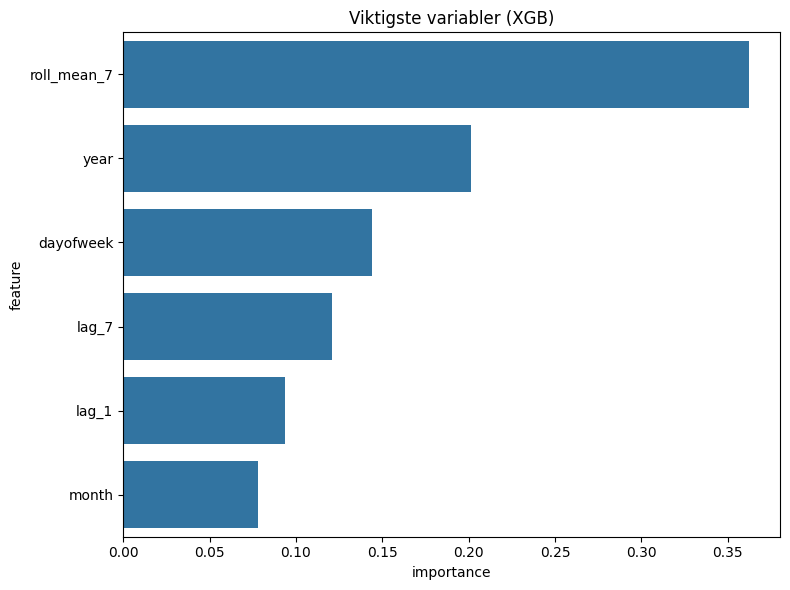

In [ ]:
# --- Visualisering og feature-viktighet: LinearRegression ---

# 1) Predikert vs. faktisk for LinearRegression
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_lin, alpha=0.5)
lims = [min(y_test.min(), y_pred_lin.min()), max(y_test.max(), y_pred_lin.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Faktisk antall salg')
plt.ylabel('Predikert antall salg')
plt.title(f'Faktisk vs. predikert, produkt {TOP_PRODUCT} (LinearRegression)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Feature-viktighet for LinearRegression
# Merk: koeffisienter er skalaavhengige. For å sammenligne rettferdig,
# standardiserer vi X_kolonner fra treningssettet og skalerer koeffisientene tilsvarende.

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Bygg en scaler på treningsdata
scaler_lr = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

# Tren en ny LR på skalerte data for ren koeffisient-tolking
linreg_scaled = LinearRegression()
linreg_scaled.fit(X_train_scaled, y_train)

# Hent koeffisienter og tegn viktighet som |coef|
coef = linreg_scaled.coef_
feat_names = list(X.columns)
imp_lr = pd.DataFrame({
    'feature': feat_names,
    'importance': np.abs(coef)   # absoluttverdi for rangering
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=imp_lr, x='importance', y='feature')
plt.title('Viktigste variabler (LinearRegression, standardiserte koeffisienter)')
plt.tight_layout()
plt.show()


# --- Visualisering og feature-viktighet ---

# Predikert vs. faktisk for XGBoost
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
lims = [min(y_test.min(), y_pred_xgb.min()), max(y_test.max(), y_pred_xgb.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Faktisk antall salg')
plt.ylabel('Predikert antall salg')
plt.title(f'Faktisk vs. predikert, produkt {TOP_PRODUCT} (XGB)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Topp 15 features fra XGB
imp = pd.DataFrame({'feature': feature_cols, 'importance': xgb.feature_importances_}) \
       .sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=imp, x='importance', y='feature')
plt.title('Viktigste variabler (XGB)')
plt.tight_layout()
plt.show()


In [ ]:
# --- Hold igjen siste 2 måneder som testsett ---

# Forsikre at Date er datetime
daily_prod_sales['Date'] = pd.to_datetime(daily_prod_sales['Date'])

# Finn dato to måneder før slutt
cutoff = daily_prod_sales['Date'].max() - pd.DateOffset(days=60)

# Splitt data
train_df = daily_prod_sales[daily_prod_sales['Date'] <= cutoff].copy()
test_df  = daily_prod_sales[daily_prod_sales['Date'] > cutoff].copy()

print(f"Treningslengde: {len(train_df)} dager, Testlengde: {len(test_df)} dager")

# Lag features for begge sett
train_df_processed, X_train2, y_train2, _ = make_prod_features(train_df)
test_df_processed, X_test2, y_test2, _ = make_prod_features(test_df)


# Tren modell (XGBoost) på treningsdata
xgb2 = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    eval_metric='rmse',
    early_stopping_rounds=30
)
xgb2.fit(X_train2, y_train2, eval_set=[(X_test2, y_test2)], verbose=False)

y_pred2 = xgb2.predict(X_test2)

Treningslengde: 273 dager, Testlengde: 26 dager


In [ ]:
from sklearn.linear_model import LinearRegression

# Tren lineær regresjon på samme train-features
linreg2 = LinearRegression()
linreg2.fit(X_train2, y_train2)

# Prediksjoner
y_pred2_lin = linreg2.predict(X_test2)

# Evaluer
print("Resultater for testperiode (samme hold-out):")
report(y_test2, y_pred2,     "XGBRegressor hold-out")
report(y_test2, y_pred2_lin, "LinearRegression hold-out")

Resultater for testperiode (samme hold-out):
XGBRegressor hold-out -> MAE: 27.13 | RMSE: 36.53 | R²: 0.228
LinearRegression hold-out -> MAE: 28.00 | RMSE: 37.22 | R²: 0.198


In [ ]:
# Bygg en daglig oversikt for testperioden med faktisk og predikert
results_daily = test_df_processed[['Date', 'SalesCount']].copy()
results_daily = results_daily.reset_index(drop=True)
results_daily['Pred_XGB'] = y_pred2
results_daily['Pred_LR']  = y_pred2_lin

# Valgfritt: rund av for penere visning
results_daily['SalesCount'] = results_daily['SalesCount'].round(2)
results_daily['Pred_XGB']   = results_daily['Pred_XGB'].round(2)
results_daily['Pred_LR']    = results_daily['Pred_LR'].round(2)

results_daily.head(10)


,Date,SalesCount,Pred_XGB,Pred_LR
0,2011-11-18,110,33.459999,42.89
1,2011-11-20,6,7.430000,26.50
2,2011-11-21,50,26.770000,49.43
3,2011-11-22,29,44.380001,45.77
4,2011-11-23,47,52.270000,50.63
5,2011-11-24,70,73.889999,57.77
6,2011-11-25,23,57.090000,49.81
7,2011-11-27,30,24.430000,41.85
8,2011-11-28,14,29.430000,40.46
9,2011-11-29,93,32.619999,53.60


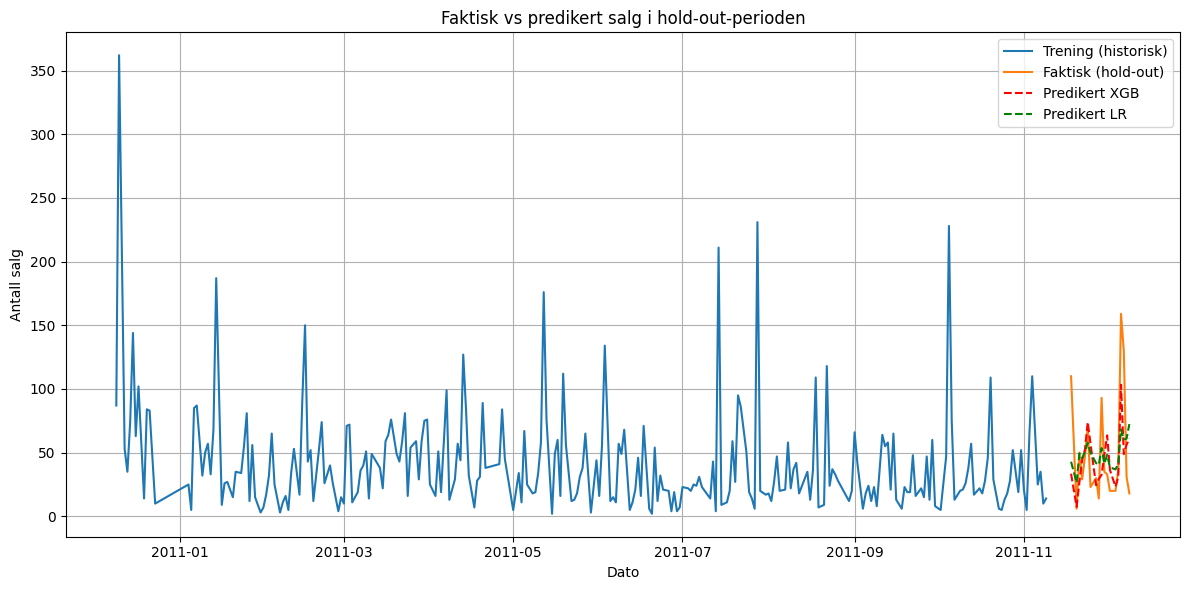

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_df_processed['Date'], train_df_processed['SalesCount'], label='Trening (historisk)')
plt.plot(test_df_processed['Date'], test_df_processed['SalesCount'], label='Faktisk (hold-out)')
plt.plot(test_df_processed['Date'], y_pred2, 'r--', label='Predikert XGB')
plt.plot(test_df_processed['Date'], y_pred2_lin, 'g--', label='Predikert LR')
plt.xlabel('Dato'); plt.ylabel('Antall salg')
plt.title('Faktisk vs predikert salg i hold-out-perioden')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

## Hvordan kan vi forbedre modellene?

Nå har vi laget to modeller (Linear Regression og XGBoost) og testet dem på en hold-out-periode. Vi så at begge modellene har et forbedringspotensial, både på nøyaktighet (lavere MAE/RMSE) og forklaringskraft (høyere R²).

Her er noen forslag til hvordan dere kan eksperimentere for å forbedre modellene:

### 1. Forbedre features (variabler)
- **Flere lags**: Vi brukte lag_1 og lag_7. Hva med `lag_2`, `lag_14`, `lag_30`?  
- **Rullerende vinduer**: Vi tok med rolling mean (7 dager). Prøv rolling mean/std på 14 eller 30 dager.  
- **Ukedag/helg**: Bruk one-hot encoding av ukedager (Mandag–Søndag). Kanskje salget har mønstre gjennom uka.  
- **Sesongmønstre**: Prøv å legge til måned, kvartal eller “er det månedsslutt/start?”. Andre ting som helligdager?

### 2. Justere modeller og hyperparametere
- **Linear Regression**: Prøv Ridge eller Lasso (regularisering) for å se om det forbedrer generalisering.  
- **XGBoost**: Test ulike `max_depth`, `learning_rate`, `n_estimators` og `subsample`. Bruk grid search eller manual tuning.

### 3. Endre trenings- og testoppsett
- **Lengre hold-out**: Test om modellen klarer å predikere 3 eller 6 måneder frem i tid.  
- **Rolling forecast**: Prøv å trene modellen frem til en dato, prediker neste dag, legg den til, og repeter. Dette speiler hvordan modeller kan brukes i praksis.  

### 4. Kombinere modeller
- Prøv å ta gjennomsnitt av Linear Regression og XGBoost sine prediksjoner. Kombinasjoner kan gi mer robuste resultater.  

### 5. Diskusjonsspørsmål
- Hvilke features tror dere har mest effekt på salget?  
- Hva er viktigst i en praktisk sammenheng: lav MAE (gjennomsnittlig feil), lav RMSE (unngå store feil), eller høy R² (forklaringskraft)?  
- Hvis dere skulle implementere modellen hos en bedrift, hvilke andre datakilder ville dere koblet på (vær, kampanjer, helligdager, etc.)?  

---  
Velg en av forslagene, implementer og se hvordan modellene endrer seg. Fortsett så lenge vi har tid.

Diskuter om:  
- Ble resultatene bedre?  
- Hvilke features eller justeringer ga mest mening?  
- Hva ville dere testet videre hvis dere hadde mer tid?


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Lag en pipeline med skalering + regresjon
linreg_scaled = make_pipeline(StandardScaler(), LinearRegression())
linreg_scaled.fit(X_train2, y_train2)
y_pred_scaled = linreg_scaled.predict(X_test2)

report(y_test2, y_pred_scaled, "LinearRegression med skalering")

LinearRegression med skalering -> MAE: 24.38 | RMSE: 31.27 | R²: 0.201
